# 04-augmentation

Goal of this notebook is to just explore the dataset, set up some basic utilities 

In [1]:
%%bash

pip install attrdict
pip install timm

In [16]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import matplotlib.pyplot as plt
import os
import tqdm

import seaborn as sns
from torchvision.io import read_image
import torchvision.transforms as T
from torchvision.utils import make_grid
from attrdict import AttrDict
import torch
import yaml
from sklearn.model_selection import StratifiedKFold
import copy
# from tqdm import tqdm_notebook


import torch
from torch import nn
import torch.nn.functional as F

from timm import create_model


In [3]:
from pawnet_utility import *

In [4]:
# check the package version to get reproducible env 
# source: https://www.kaggle.com/rtatman/get-the-versions-of-imported-packages

"""
To be used for kaggle notebook
"""

import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system names
        if name == "PIL":
            name = "Pillow"
        elif name == "sklearn":
            name = "scikit-learn"

        yield name
imports = list(set(get_imports()))

requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))

tqdm==4.62.3
torchvision==0.10.1+cpu
torch==1.9.1+cpu
seaborn==0.11.2
scikit-learn==0.23.2
pandas==1.3.3
numpy==1.19.5
matplotlib==3.4.3


In [5]:
# load config

base_config_manager = BaseConfigLoader("../input/d/germmie/config/config.yaml")
# model_config = base_config_manager.load_config().

# Loading Data

We will load the data by creating torch datasets as well as dataloader

In [6]:
# this is specific to kaggle
# if running in GCS, replace with our GCP bucket 
# get cache location of the dataset 
# GCS_DS_PATH = KaggleDatasets().get_gcs_path()
file_path = base_config_manager.load_config().filepath.kaggle #"/kaggle/input/petfinder-pawpularity-score/"


train_df = pd.read_csv(os.path.join(file_path,"train.csv"))
test_df = pd.read_csv(os.path.join(file_path,"test.csv"))


In [7]:
train_df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [8]:
test_df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur
0,4128bae22183829d2b5fea10effdb0c3,1,0,1,0,0,1,1,0,0,1,0,1
1,43a2262d7738e3d420d453815151079e,0,1,0,0,0,0,1,1,0,0,0,0
2,4e429cead1848a298432a0acad014c9d,0,0,0,1,0,1,1,1,0,1,1,1
3,80bc3ccafcc51b66303c2c263aa38486,1,0,1,0,0,0,0,0,0,0,1,0
4,8f49844c382931444e68dffbe20228f4,1,1,1,0,1,1,0,1,0,1,1,0


In [9]:
# create loaders - just for visualization
# for visualization, we need them to be in the same size
file_path = "/kaggle/input/petfinder-pawpularity-score/"
train_data = pawnetDataset(annotation_df=train_df,img_dir = os.path.join(file_path,"train"),transform = T.Compose([T.Resize([224,224])]))
test_data = pawnetDataset(annotation_df=test_df,img_dir = os.path.join(file_path,"test"),transform = T.Compose([T.Resize([224,224])]),test=True)
train_loaders = torch.utils.data.DataLoader(train_data,batch_size=30,shuffle=False)
test_loaders = torch.utils.data.DataLoader(test_data,batch_size=39,shuffle=False)

In [10]:
# helper to visualize
# https://towardsdatascience.com/beginners-guide-to-loading-image-data-with-pytorch-289c60b7afec

def visualize_images(images,nmax):
    """
    visual images in our loaders
    
    Parameters
    ---------
    images: image tensor of size (N,H,W,C)
    nmax: max number of images to plot
    """
    fig,axes = plt.subplots(figsize=(16,16))
    axes.set_xticks([])
    axes.set_yticks([])
    axes.imshow( make_grid((images.detach()[:nmax]),nrow=6).permute(1,2,0)) # H,W,C
    plt.savefig("train_batch_images.png")
    
def visualize_batch_images(data_loaders,nmax=64):
    images, labels = iter(data_loaders).next() # get batch size of image tensor
    visualize_images(images,nmax=nmax)

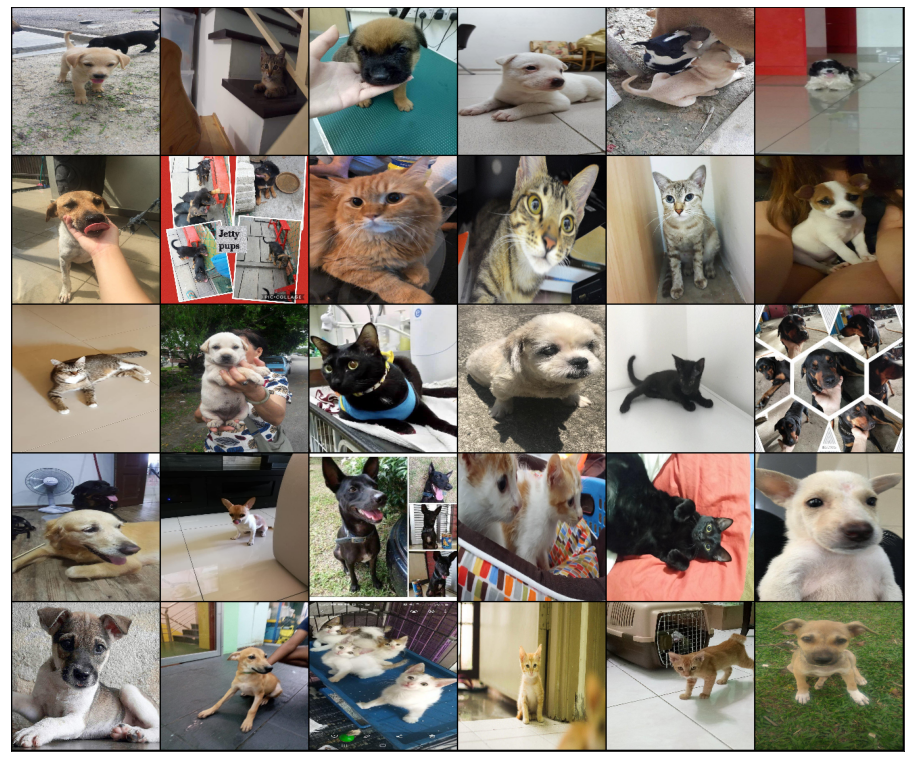

In [11]:
visualize_batch_images(train_loaders)

In [12]:
"""
All pre-trained models expect input images normalized in the same way, 
i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), 
where H and W are expected to be at least 224. 
The images have to be loaded in to a range of [0, 1] and then 
normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]. 
You can use the following transform to normalize:

https://pytorch.org/vision/stable/models.html

"""
train_transformation = T.Compose(
            [
                T.Resize([224,224]),# imgnet needs at least 224
                T.RandomHorizontalFlip(),
                T.RandomVerticalFlip(),
                T.RandomAffine(15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
                T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
                T.ConvertImageDtype(torch.float),
                T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225] ), # imgnet requirements 
            ]
        )
# train_data = pawnetDataset(annotation_df=train_df,img_dir = os.path.join(file_path,"train"),transform = train_transformation)
# # batchsize should be parameter in config
# train_loader = torch.utils.data.DataLoader(train_data,batch_size=64,num_workers =2, shuffle=True)


test_transformation = T.Compose([
                T.Resize([224,224]),# imgnet needs at least 224
                T.ConvertImageDtype(torch.float),
                T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225] ), # imgnet requirements 
                ]
            )

In [17]:
train_data = pawnetDataset(annotation_df=train_df,img_dir = os.path.join(file_path,"train"),transform = train_transformation)
train_loaders = torch.utils.data.DataLoader(train_data,batch_size=30,shuffle=False)

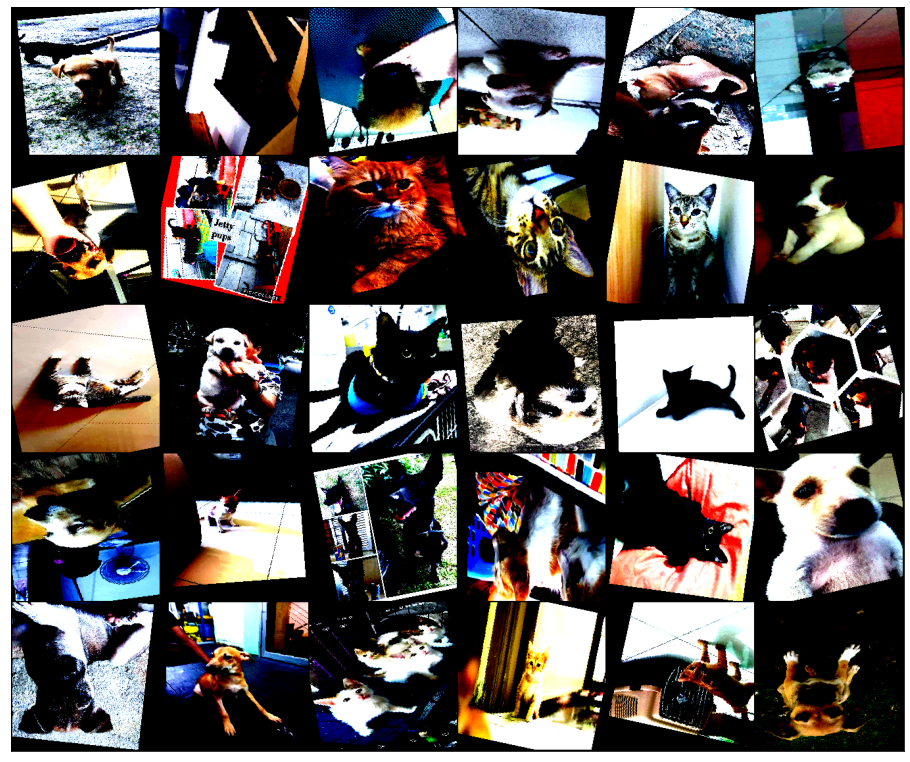

In [14]:
visualize_batch_images(train_loaders)

# Mix up 


In [99]:
train_data = pawnetDataset(annotation_df=train_df,img_dir = os.path.join(file_path,"train"),transform = T.Compose([T.Resize([224,224]),T.ConvertImageDtype(torch.float),
                T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225] )]))
# train_data = pawnetDataset(annotation_df=train_df,img_dir = os.path.join(file_path,"train"),transform = train_transformation)
train_loaders = torch.utils.data.DataLoader(train_data,batch_size=30,shuffle=False)

In [100]:
images, labels = iter(train_loaders).next() # get batch size of image tensor

In [101]:
indices = torch.randperm(len(images))
# shuffle images
# https://discuss.pytorch.org/t/shuffling-a-tensor/25422/9
new_images = images[indices].view(images.size())
# shuffle target
new_labels = labels[indices].view(labels.size())

In [108]:
alpha = 0.5
beta_distribution = torch.distributions.beta.Beta(alpha,alpha)
t = beta_distribution.sample(sample_shape=torch.Size([len(images)]))
tx = t.view(-1,1,1,1)
ty = t.view(-1)
x = (images * tx) + (new_images * (1-tx))
y = labels * ty + new_labels * (1-ty)

In [120]:
def visualize_mixup(mixedup_images,images):
    """
    visual images in our loaders
    
    Parameters
    ---------
    images: image tensor of size (N,H,W,C)
    nmax: max number of images to plot
    """
    fig,axes = plt.subplots(figsize=(16,5),nrows=2)
    axes[0].set_title("Mix up batch of images")
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    axes[0].imshow( make_grid((mixedup_images.detach()),nrow=5).permute(1,2,0)) # H,W,C
    
    axes[1].set_title("Original batch of images")
    axes[1].set_xticks([])
    axes[1].set_yticks([])
    axes[1].imshow( make_grid((images.detach()),nrow=5).permute(1,2,0)) # H,W,C
    
    plt.savefig("mixup.png")

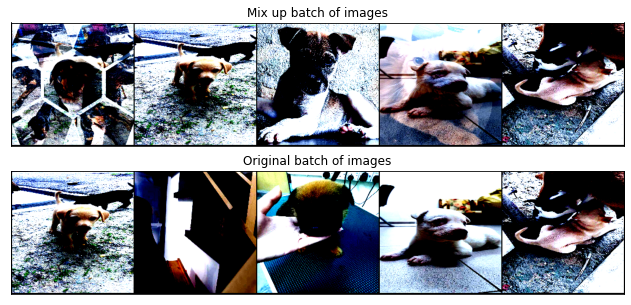

In [121]:
# this shows the first 5 images between batch of mixup and batch of OG
# however since batch size is 30, the mixup is amongst the 30 
visualize_mixup(x[:5],images[:5])